# Text generation

The goal of this project is to demonstrate text generation using LSTM neural networks.
Our database contains numerous movie plots taken from Wikipedia, so we will generate something similiar.

In [126]:
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from keras.utils import to_categorical
from keras.preprocessing.sequence import pad_sequences
from keras.layers import LSTM, Dense, Dropout, Embedding
from keras.models import Sequential
import random 
import matplotlib.pyplot as plt
import warnings
import os, multiprocessing

warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)


In [127]:
# Computer characteristics

mem_bytes = os.sysconf('SC_PAGE_SIZE') * os.sysconf('SC_PHYS_PAGES')
mem_gib = mem_bytes / (1024.**3)
print("Computer characteristics: ")
print("RAM: %f GB" % mem_gib)
print("CORES: %d" % multiprocessing.cpu_count())


Computer characteristics: 
RAM: 7.653069 GB
CORES: 4


In [128]:
data = pd.read_csv("movie_plots.csv")

movie_plots = data['Plot']

def count_words(text):
    return len(text.split())

print("Max movie plot len: ", movie_plots.map(count_words).max())
print("Min movie plot len: ", movie_plots.map(count_words).min())


# zadrzavamo samo opise sa vise od 300 reci
movie_plots = movie_plots[movie_plots.map(count_words) > 299]
print("Min movie plot len: ", movie_plots.map(count_words).min())
# i zadrzavamo sve koji imaju manje od 500 reci
movie_plots = movie_plots[movie_plots.map(count_words) < 501]
print("Max movie plot len: ", movie_plots.map(count_words).max())

all_plots = list(movie_plots.values)
# setting a seed so we get the same result every time
random.seed(64)
sample = random.sample(all_plots, 100)
sample[0]

Max movie plot len:  6752
Min movie plot len:  2
Min movie plot len:  300
Max movie plot len:  500


'Set in the 1920s during China\'s Warlord Era, The Wooden Man\'s Bride is a romance film between two unlikely people from different classes. A young woman, known only as "Young Mistress" (Wang Lan), is on her way to meet her future husband for the first time when her procession is attacked by sword-wielding bandits in the desert. A servant, Kui (Chang Shih) recklessly takes off after the bandits who have kidnapped the young mistress and taken her back to their lair. When he arrives, Kui impresses the chief of the bandits (Kao Mingjun), who allows Kui to take the Young Mistress back.\r\nMeanwhile, word has reached the Young Mistress\'s fiancé of her capture. Preparing to engage in a thrilling rescue, the hapless young man accidentally sets off an explosion, killing him. When Young Mistress finally arrives, she faces her fiancé\'s imperious mother (Wang Yumei), who forces the young woman to undergo arcane tests of purity to determine whether she is worthy to marry the (now dead) bridegro

## Tokenize words

Tokenization is turning unique words into unique integers. This step is necessary for preparing data for embedding layer.

In [129]:
from keras.preprocessing.text import Tokenizer

max_words = 10000
tokenizer = Tokenizer(num_words = max_words)
tokenizer.fit_on_texts(sample)

reverse_word_map = dict(map(reversed, tokenizer.word_index.items()))


sequences = tokenizer.texts_to_sequences(sample)
sequences_len = 300
sequences = pad_sequences(sequences, maxlen = sequences_len, truncating = 'post')


sequences.shape
print(sequences[64])

[ 820 2992    5    1   51    6    1 5646 5647    6    9  191   21   24
   64    1 2822  257   16    1  437 2993  109  820    9   67    3    1
  191  752   28 5648   17  974 5649    3 1194 5650 5651  664 2994 2995
   51 1526 5652  120    2    1  191   23    1 1038  738    2  138 1527
 5653 1422    1 5654   96    6  974    3    4  125    6 2994 1066   16
   15    2  169   18    8   81  236    2  169 1528  102 1195 5655    4
 1092 5656  125 1194  185    2    1  159   32    8  920   12    1 2815
  425   46 1528   53   66 5657    2    1 1529 2907 5658 5659 5660    8
 1319    1  425   20 1317  376   71    1 2967  159 1528   53  171    2
   73   30   44   23    1 1529 1194 5661    1  159  974    5 2990   17
 1196 1066   18 2531    1 1529  840   25  425    3  160    4 1243   11
 1194 1196  159    5 5662   11 1527  228    9 1475  174   30   95  805
 1475   12 1195    5  801   11 1196  498 1528   53 2050  315   26    8
  920   12    1 1529   43  611   25  425  820    3 1195  725    2    1
  190 

In [130]:
# making a single list of tokens so we can apply sliding windows

text = [item for sublist in sequences for item in sublist]
print("Corpus size: ", len(text))
vocab_size = len(tokenizer.word_index)
print("Vocabulary size: ", vocab_size+1)


Corpus size:  30000
Vocabulary size:  7042


In [131]:
# reverse dictionary so we can decode tokenized sequences back to words

reverse_word_map = dict(map(reversed, tokenizer.word_index.items()))


### Splitting the data for input and output values

Input sequence has the size of 20 words, and output is the next word

In [132]:
seq_len = 20

dataX = []
dataY = []

for i in range(len(text)-seq_len):
    seq_in = text[i:i+seq_len]
    seq_out = text[i+seq_len]
    dataX.append(seq_in)
    dataY.append(seq_out)
    
    
lenX = len(dataX)
print(lenX)

29980


In [133]:
from keras.utils import np_utils

dataX = np.asarray(dataX)
dataY = np_utils.to_categorical(dataY)

### Split into train and test set

In [134]:
from sklearn.model_selection import train_test_split


trainX, testX, trainy, testy = train_test_split(dataX, dataY, test_size = 0.2)
print(trainX.shape)
print(testX.shape)
print(trainy.shape)
print(testy.shape)

(23984, 20)
(5996, 20)
(23984, 7018)
(5996, 7018)


### Creating a model

In [135]:
import keras
from keras.layers import LSTM, Dense, Embedding, Dropout
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint

model = Sequential()
model.add(Embedding(vocab_size+1, 32, input_length = trainX.shape[1]))
model.add(LSTM(200,  return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(200))
model.add(Dense(trainy.shape[1], activation = 'softmax'))

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 20, 32)            225344    
_________________________________________________________________
lstm_5 (LSTM)                (None, 20, 200)           186400    
_________________________________________________________________
dropout_3 (Dropout)          (None, 20, 200)           0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 200)               320800    
_________________________________________________________________
dense_3 (Dense)              (None, 7018)              1410618   
Total params: 2,143,162
Trainable params: 2,143,162
Non-trainable params: 0
_________________________________________________________________


In [136]:
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['acc'])

filepath = "./weights.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor = 'loss', 
                             verbose = 1, save_best_only = True, mode = 'min')
callbacks = [checkpoint]

hist = model.fit(trainX, trainy, epochs = 20, batch_size = 128, 
                 verbose = 1, callbacks = callbacks, validation_split = 0.2)


Train on 19187 samples, validate on 4797 samples
Epoch 1/20
19187/19187 [==============================] - 67s 3ms/step - loss: 7.4556 - acc: 0.0561 - val_loss: 7.2151 - val_acc: 0.0532

Epoch 00001: loss improved from inf to 7.45556, saving model to ./weights.hdf5
Epoch 2/20
19187/19187 [==============================] - 79s 4ms/step - loss: 6.8574 - acc: 0.0569 - val_loss: 7.2796 - val_acc: 0.0532

Epoch 00002: loss improved from 7.45556 to 6.85742, saving model to ./weights.hdf5
Epoch 3/20
19187/19187 [==============================] - 83s 4ms/step - loss: 6.7263 - acc: 0.0569 - val_loss: 7.2566 - val_acc: 0.0532

Epoch 00003: loss improved from 6.85742 to 6.72626, saving model to ./weights.hdf5
Epoch 4/20
19187/19187 [==============================] - 85s 4ms/step - loss: 6.6037 - acc: 0.0643 - val_loss: 7.3321 - val_acc: 0.0638

Epoch 00004: loss improved from 6.72626 to 6.60369, saving model to ./weights.hdf5
Epoch 5/20
19187/19187 [==============================] - 85s 4ms/step 

In [18]:
filename = "20e100n.hdf5"
model.load_weights(filename)
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['acc'])


In [137]:
# Evaluate model on test set (accuracy and error)

print(model.metrics_names)
results = model.evaluate(testX, testy, batch_size = 128)
print('Loss: %.2f'% results[0])
print('Accuracy: %.2f'%(results[1]*100), "%")

['loss', 'acc']
5996/5996 [==============================] - 10s 2ms/step
Loss: 8.15
Accuracy: 7.49 %


### Plot za trening skup (preciznost)

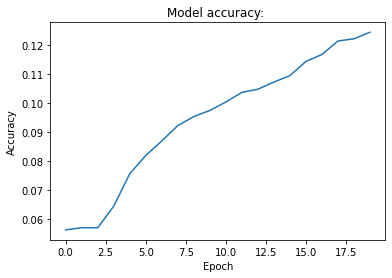

In [138]:
plt.plot(hist.history["acc"])
plt.title('Model accuracy: ')
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.show()


### Plot za trening i val skup (preciznost)

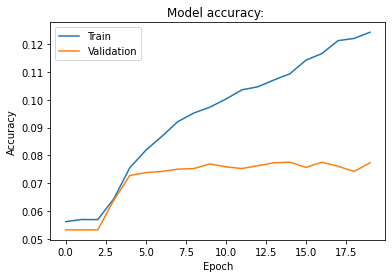

In [139]:
plt.plot(hist.history["acc"])
plt.plot(hist.history["val_acc"])
plt.title('Model accuracy: ')
plt.legend(['Train', 'Validation'], loc='best')
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.show()

### Plot za trening skup (greska)

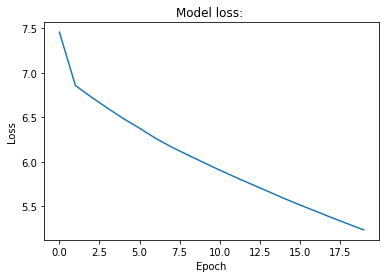

In [140]:
plt.plot(hist.history["loss"])
plt.title('Model loss: ')
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.show()


### Plot za trening i val skup (greska)

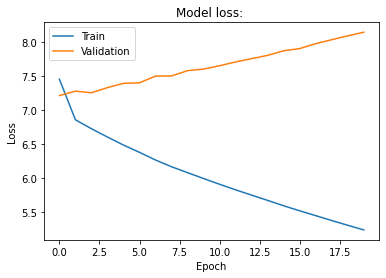

In [141]:
plt.plot(hist.history["loss"])
plt.plot(hist.history["val_loss"])
plt.title('Model loss: ')
plt.legend(['Train', 'Validation'], loc='best')
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.show()

In [142]:
def generate_words(seed_text, num_words, model, max_seq_len = 20):
    for i in range(num_words):
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = pad_sequences([token_list], maxlen = max_seq_len, padding = 'pre')
        
        predicted = model.predict_classes(token_list, verbose = 0)
        output_word = ''
        for word, index in tokenizer.word_index.items():
            if index == predicted:
                output_word = word
                break
                
        seed_text = seed_text + " " + output_word
        
    return seed_text.title()

In [143]:
print(generate_words("The movie", 50, model))

The Movie Of The Police Is Is Not Only Is Is Not Be Is Is Not Father And Is Not In The Police And Is Is Not Be Is Is Not Father And Is Not In The Police And Is Is Not Be Is Is Not Father And Is Not In The
